# LEEM Image stitching
##### Author: Tobias A. de Jong (jongt@physics.leidenuniv.nl)
This notebook facilitates image stitching of overlapping images. It is designed for use with ESCHER LEEM images. 
For those images, their positions are known approximately in terms of _stage coordinates_,  i.e. the positions as reported by the sensors in the sample stage. It should however generalize to any set of overlapping images where relative positions of the images are known in some coordinate system which can approximately be transformed to coordinates in terms of pixels by an affine transformation (rotation, translation, mirroring).

The algorithm consists of the following steps:
  
 1. Using the stage coordinates for each image, obtain a nearest neighbour graph with the nearest `n_neighbors` neighbouring images for each image.
 2. Obtain an initial guess for the transformation matrix between stage coordinates and pixel coordinates, by one of the following options:
  1. Copying a known transformation matrix from an earlier run of a comparable dataset.
  2. Manually overlaying some nearest neighbor images from the center of the dataset, either refining the estimate, or making a new eastimate for an unknown dataset
 3. Calculate an initial estimate of the pixel coordinates of the images by applying the corresponding transformation to the stage coordinates
 4. Apply a gaussian filter with width `sigma` to the original dataset and apply a magnitude sobel filter. Optionally scale down the images by an integer factor `z` in both directions to be able to reduce `fftsize` by the same factor, without reducing the sample area compared.
 5. Iterate the following steps until the calculated image positions have converged to within `sigma`:
  1. Obtain a nearest neighbour graph with per image the nearest `n_neighbors` neighbouring images from the current estimate of the pixel coordinates and calculate the difference vectors between each pair of nearest neighbours.
  2. For each pair of neighboring images: 
     1. Calculate the cross-correlation between areas estimated to be in the center of the overlap of size `fftsize*fftsize` of the filtered data. 
     If the estimated area is outside the valid area of the image defined by `mask`/`radius`, take an area as close to the intended area but still within the valid area as possible.
     2. Find the location of the maximum in the cross-correlation. This corresponds to the correction to the estimate of the difference vector between the correspondingimage position pair.
     4. Calculate the weight of the match by dividing the maximum in the cross-correlation by the sqrt of the maximum of the auto-correlations.
  3. Compute a new estimate of the difference vectors by adding the found corrections. Reconvert to a new estimate of pixel coordinates by minimizing the squared error in the system of equations for the positions, weighing my modified weights, either:
     1. $w_{mod}= w - w_{min}$ for $w> w_{min}$, $w=0$ else, with w_min the maximum lower bound such that the graph of nearest neighbours with non-zero weights is still connected
     2. Only use the 'maximum spanning tree' of weights, i.e. minus the minimum spanning tree of minus the weights, such that only the $n$ best matches are used.
 6. (Optional) Refine the estimate of the transformation matrix, using all estimated difference vectors with a weight better than $w_{min est}$ and restart from step 3.
 7. Repeat step 4. and 5. until `sigma` is satisfactory small. Optional repeat a final time with the original data if the signal to noise of the original data permits.
 8. Select only the images for stitching where the average of the used weights (i.e. where $w > w_{min}$) is larger than $q_{thresh}$ for an appropiate value of $q_{thresh}$.
 9. (Optional) For those images, match the intensities by calculating the intensity ratios between the overlap areas of size `fftsize*fftsize` and perform a global optimization.
 10. Define a weighting mask, 1 in the center and sloping linearly to zero at the edges of the valid region, over a width of `bandwidth` pixels.
 11. Per block of output `blocksize*blocksize`, select all images that have overlap with the particular output block, multiply each by the weighting mask and shift each image appropriately. Divide by an equivalently shifted stack of weighting masks. As such information at the center of images gets prioritized, and transitions get smoothed.

## Considerations

For square grids with a decent amount of overlap, it makes sense to put `n_neighbors`  to 5 (including the image itself), however, for larger overlaps or datasets where an extra dimension is available (such as landing energy), it can be appropiate to increase the number of nearest neighbors to which each image is matched.

Parameters and intermediate results of the iteration are saved in an `xarray` and saved to disk for reproducability.


## Parallelization

Using [`dask`](https://dask.org), the following steps are parallelized:
  
* step 5B , where each pair of images can be treated independently. In practice parallelization is eprformed over blocks of subsequent images with their nearest neighbours. 
This could be improved upon in two ways: firstly by treating each pair only once, and secondly by making a nicer selection of blocks of images located close to eachother in the nnb graph. This would most likely require another (smarter) data structure than the nearest neighbour indexing matrix used now.
* Step 6 is actually quite analogous to 5B and is parallelized similarly.
* Step 11 is parallelized on a per block basis. To optimize memory usage, results are directly streamed to a `zarr` array on disk.
* The minimizations are parallelized by scipy natively.
  

In [1]:
import time
import os
import datetime
import matplotlib.pyplot as plt
import matplotlib
import datetime

import numpy as np
import scipy.ndimage as ndi
import numba

import dask
import dask.array as da
from dask.delayed import delayed
from dask.distributed import Client, LocalCluster
import xarray as xr

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from sklearn.neighbors import NearestNeighbors

import zarr

from registration.stitching import *


In /home/tobias/anaconda3/envs/LEEM-analysis/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/tobias/anaconda3/envs/LEEM-analysis/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/tobias/anaconda3/envs/LEEM-analysis/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/tobias/anaconda3/envs/LEEM-analysis/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor 

In [3]:
# To use this way, first start a dask-scheduler with some workers at the address, see http://docs.dask.org/en/latest/setup/cli.html
# Otherwise client= Client() also works by default.
cluster = LocalCluster(n_workers=1, threads_per_worker=6)
client = Client(cluster)
client

/home/tobias/anaconda3/envs/LEEM-analysis/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38751 instead
  http_address["port"], self.http_server.port


## Initializing the required data
From a container with both stage coordinates and images, and associated metadata. The data used to showcase here is not (yet) publicly available, but corresponds to the Dark Field data of twisted bilayer graphene in Fig. 2c of [Lisi, S., Lu, X., Benschop, T. et al. Observation of flat bands in twisted bilayer graphene. Nat. Phys. 17, 189–193 (2021).](https://doi.org/10.1038/s41567-020-01041-x).

Please note: that figure corresponds to the results of an earlier, unreleased version, of this code.

In [2]:
PEEM = False
folder = './data'
name = '20191105_212845_5.7um_349.0_sweep-STAGE_X-STAGE_Y_closed_loop_DF'

In [5]:
container = xr.open_dataset(os.path.join(folder, name+'.nc'), chunks={'index': 1})
container

<xarray.Dataset>
Dimensions:      (dir: 2, index: 130, x: 1280, y: 1024)
Coordinates:
  * index        (index) int64 0 1 2 3 4 5 6 7 ... 123 124 125 126 127 128 129
  * dir          (dir) object 'x' 'y'
  * x            (x) int64 0 1 2 3 4 5 6 ... 1273 1274 1275 1276 1277 1278 1279
  * y            (y) int64 0 1 2 3 4 5 6 ... 1017 1018 1019 1020 1021 1022 1023
Data variables:
    stagecoords  (dir, index) float64 dask.array<chunksize=(2, 1), meta=np.ndarray>
    multiplier   (index) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    data         (index, x, y) uint16 dask.array<chunksize=(1, 1280, 1024), meta=np.ndarray>
Attributes:
    nmperpixel:  4.453125
    LNS:         Dark Field 1 / 5.7 um low

In [6]:
stagecoords = container.stagecoords.data.compute()
data = container.data.data
index = container.index.data
nmperpixel = container.nmperpixel
multipliers = container.multiplier.data.compute()

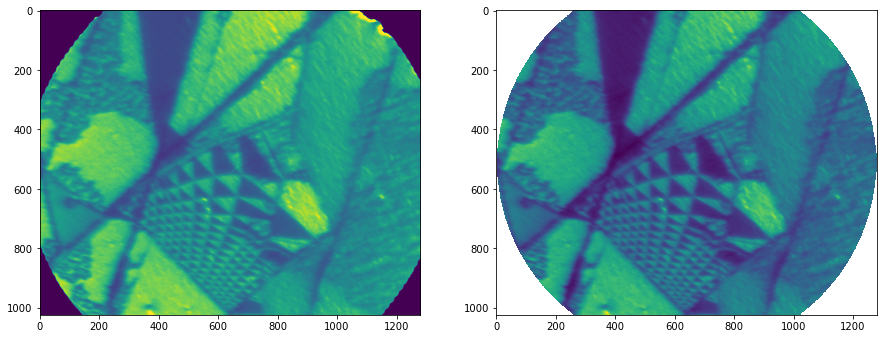

In [7]:

dims = data.shape
xx, yy = np.meshgrid(np.arange(-dims[2]//2, dims[2]//2), np.arange(-dims[1]//2, dims[1]//2))
if PEEM:
    outer_radius = 350
else:
    outer_radius = 640
mask = (xx)**2 + (yy)**2 < outer_radius**2

fig,axs= plt.subplots(ncols=2, figsize=[15,8])
axs[0].imshow(data[len(data)//2].T, vmax=(np.nanmean(data[len(data)//2])*2))
axs[1].imshow(np.where(mask, data[len(data)//2], np.nan).T)#, vmax=(data[len(data)//2].mean()*2))

In [8]:
def plot_stack(images, n):
    """Plot the n-th image from a stack of n images.
    For interactive use with ipython widgets"""
    im = images[n, :, :].compute()
    plt.figure(figsize=[12,12])
    plt.imshow(im.T, cmap='inferno')#, vmax=im.mean()*2)
    plt.show()
    
interactive(lambda n: plot_stack(data, n), 
            n=widgets.IntSlider(1, 0, data.shape[0]-1, 1, continuous_update=False)
           ) 

interactive(children=(IntSlider(value=1, continuous_update=False, description='n', max=129), Output()), _dom_c…

## Optional: discard dark images

Too dark images (e.g. Si substrate next to vdW flakes), will only take up computation time and distort results, so we can crop them out in the next two cells

In [9]:
base_extent = np.array([-dims[1]//2,dims[1]//2,-dims[2]//2, dims[2]//2])
Is = np.nanmax(np.where(mask, data, np.nan), axis=(1,2)) / multipliers
Is = Is.compute()

def I_mask_plot(ratio=3.5):
    I_mask = []
    fig, ax = plt.subplots(figsize=[4*2,8])
    I_thresh = Is.max() / ratio
    lsc = stagecoords
    scat1 = ax.scatter(*lsc[:,Is >= I_thresh], 
                c=Is[Is>=I_thresh], vmin=0, vmax=Is.max())
    scat2 = ax.scatter(*lsc[:,Is<I_thresh], c=Is[Is<I_thresh], 
               vmin=0, vmax=Is.max(), marker='x')

    #for i,im in enumerate(data):
    #    plt.annotate(str(i), stagecoords[:,i])
    I_mask= (Is >= I_thresh)
    plt.colorbar(scat1, ax=ax)
    ax.set_aspect('equal')
    return I_mask

widget = interactive(I_mask_plot, ratio=(1.1,Is.max()/Is.min()+0.1,0.1)
               )
display(widget)

interactive(children=(FloatSlider(value=3.5, description='ratio', max=4.186364634398706, min=1.1), Output()), …

In [10]:
I_mask = widget.result

data = data[I_mask]
stagecoords = stagecoords[:,I_mask]
multipliers = multipliers[I_mask]

## More initialization
Initialize the output xarray containing all the metadata of the progress.

In [11]:
center = np.mean(stagecoords, axis=1)
fftsize = 256*4 // 2
n_neighbors = 1 + 4 # sklearn nearest neighbors includes the point itself

In [12]:
output = xr.Dataset(
            {"multiplier": (['index'], multipliers),
             "fftsize": (['iteration'], [fftsize]),
            },
            coords = {
                "index": index[I_mask],
                "direction": ["x", "y"],
                "iteration": [0],
                "neighbor_no": np.arange(n_neighbors),
            }
)
output.attrs["scriptversion"] = 'v10'
output.attrs["center"] = center
output

<xarray.Dataset>
Dimensions:      (direction: 2, index: 128, iteration: 1, neighbor_no: 5)
Coordinates:
  * index        (index) int64 0 1 4 5 6 7 8 9 ... 123 124 125 126 127 128 129
  * direction    (direction) <U1 'x' 'y'
  * iteration    (iteration) int64 0
  * neighbor_no  (neighbor_no) int64 0 1 2 3 4
Data variables:
    multiplier   (index) float64 2.47e+06 2.583e+06 ... 7.621e+05 1.989e+06
    fftsize      (iteration) int64 512
Attributes:
    scriptversion:  v10
    center:         [0.80721508 0.38407695]

## Finding the initial nearest neighbors 
For a simple square lattice with minimal overlap, the number of nearest neighbors is $4+1$, i.e. the image itself and it's horizontal and vertical neighbors. For larger overlaps or overlays, a larger number of neighbors may be specified.

In [13]:
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree').fit(stagecoords.T)
nn = nbrs.kneighbors(stagecoords.T, return_distance=False)
output["nnbs"] = (("iteration", "indices", "neighbor_no"), [nn])

Text(0.5, 1.0, 'Stage coordinate differences\n between nearest neighbors.')

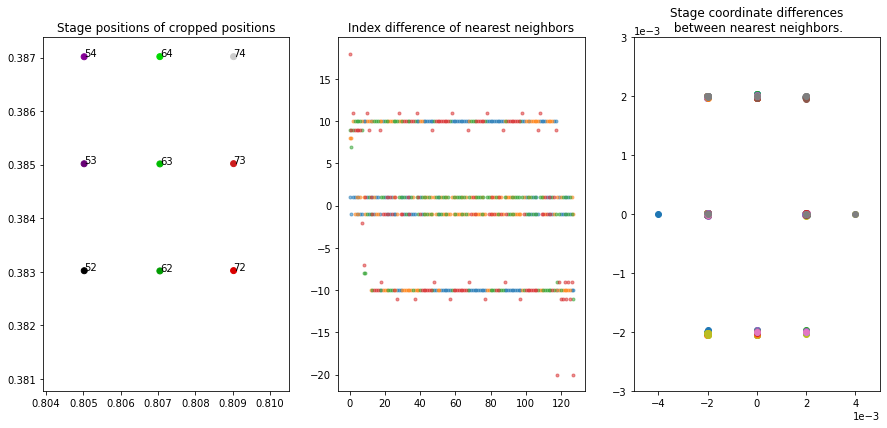

In [14]:

if PEEM:
    r = 0.05
else:
    r = 0.003
cropindices, = np.where((np.abs(stagecoords[0]-center[0]) < r)
                       & (np.abs(stagecoords[1]-center[1]) < r))
cropnbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree').fit(stagecoords[:,cropindices].T)
cropstagecoords = stagecoords[:,cropindices]
cnb = cropnbrs.kneighbors(cropstagecoords.T, return_distance=False).squeeze()

fig, axs = plt.subplots(ncols=3, figsize=(15,6.5))

axs[0].scatter(*cropstagecoords, c=cropindices, cmap='nipy_spectral')
axs[0].set_xlim(center[0]-r*1.1, center[0]+r*1.1)
axs[0].set_ylim(center[1]-r*1.1, center[1]+r*1.1)
for i in range(len(cropindices)):
    axs[0].annotate(str(cropindices[i]), cropstagecoords[:,i])
axs[0].set_title('Stage positions of cropped positions')

axs[1].plot(nn[:,1:]-nn[:,0][...,np.newaxis],'.', alpha=0.5)
axs[1].set_title('Index difference of nearest neighbors')
for x in nn:
    axs[2].scatter(stagecoords[0][x[0]]- stagecoords[0][x[1:]], stagecoords[1][x[0]]- stagecoords[1][x[1:]])
axs[2].set_xlim(-0.005, 0.005)
axs[2].set_ylim(-0.003, 0.003)
axs[2].set_title('Stage coordinate differences\n between nearest neighbors.')

## 2A: Predetermined approximate transformation matrices

In [15]:
LNS = container.attrs["LNS"]
if '5.7 um' in LNS:
    FoV = "5.7 um"
    # 5.7um 18eV
    #A_calc = np.array([[   2643.39574684,  256157.63546798],
    #                   [-211200.54223502,    9852.21674877]])
    # 5.7um 18eV, re-estimate based on best matches
    #A_calc = np.array([[   4082.15139025,  248042.15443774],
    #                [-219271.06227564,   12336.31827313]])
    # 5.7um 8eV, re-estimate based on best matches
    #array([[   9086.96378958,  244718.34754219],
    #        [-211057.05649402,   13839.03554334]])
    A_calc = np.array([[  10561.34,  250889.  ],
                       [-266954.5,   31157.17]] )
elif '2.3 um' in LNS:
    FoV = "2.3 um"
    #2.3um, initial estimate
    A_calc = np.array([[ -14446.74981648, -739030.02309468],
                       [ 793733.26137892, -115473.44110854]])
elif '0.66 um' in LNS:
    FoV = "0.66 um"
    #0.66um, initial estimate
    A_calc = np.array([[-250395.70614198, -909469.57525559],
                       [1041569.97155636, -247301.46262504]])
else:
    FoV = "unknown"
    print("WARNING: Unknown Field of View.")
output.attrs["FoV"] = FoV
FoV

'5.7 um'

## Step 2B: Manual overlap images
Can be skipped if a sufficient estimate is available in 2A. TODO: estimate shift with estimate from 2A it exists.

In [ ]:
#Either use this to manually overlap two images, or go down to try all four sides

#centerindex = np.argmin(np.linalg.norm(cropstagecoords.T-center, axis=1))
centerindex = np.argmin(np.abs(cropindices-27))
data[cropindices[centerindex]].persist()
matchdata = data[cropindices[cnb[centerindex]]]
vmax = np.nanmax(matchdata)
print(cropindices[centerindex])
z = 10
def plotoverlayshift(dx, dy, matchindex=2):
    fig, axs = plt.subplots(ncols=1, figsize=[15,15])

    match = cnb[centerindex][matchindex]
    #axs.imshow(np.where(mask, data[cropindices][centerindex], 0).T, vmax=vmax, origin='lower')
    axs.imshow(np.where(mask, matchdata[0], 0).T, vmax=vmax, origin='lower')
    #s = shift(np.where(mask, data[cropindices][match], 0), (z*dx,z*dy))
    s = shift(np.nan_to_num(matchdata[matchindex]), (z*dx,z*dy))
    axs.annotate(str(cropindices[match]), (640+z*dx, 512+z*dy))
    axs.imshow(s.T, cmap='inferno', vmax=vmax, zorder=2, origin='lower', alpha=0.6,)
    return np.array([z*dx, z*dy]), match
  
print(cropindices[cnb[centerindex]])

widget = interactive(plotoverlayshift, 
                dx=widgets.IntSlider(value=0, min=-dims[1]//z, max=dims[1]//z, continuous_update=False),
                dy=widgets.IntSlider(value=-43, min=-dims[2]//z, max=dims[2]//z, continuous_update=False),
                matchindex=4
               )
display(widget)

        
widget2 = interactive(plotoverlayshift, 
                dx=widgets.IntSlider(value=-52, min=-dims[1]//z, max=dims[1]//z, continuous_update=False),
                dy=widgets.IntSlider(value=-2, min=-dims[2]//z, max=dims[2]//z, continuous_update=False),
                matchindex=3
               )
display(widget2)

In [ ]:
S, P = np.empty((2,2)), np.empty((2,2))
matchindex = [0,0]
P[:,0], matchindex[0] = widget.result
P[:,1], matchindex[1] = widget2.result
S =  cropstagecoords[:, matchindex] - cropstagecoords[:, [centerindex]]
print(f'P = {P},\n S = {S},\n S^-1 = {np.linalg.inv(S)}')
A_calc = P @ np.linalg.inv(S)
A_calc, np.linalg.svd(A_calc)[1]*nmperpixel/1e6

**Continue from here if you skipped 2B.**

In [16]:
output["A_calc"] = (['iteration', 'direction', 'direction2'], [A_calc]) #todo: make nicer direction coordinates
output

<xarray.Dataset>
Dimensions:      (direction: 2, direction2: 2, index: 128, indices: 128, iteration: 1, neighbor_no: 5)
Coordinates:
  * index        (index) int64 0 1 4 5 6 7 8 9 ... 123 124 125 126 127 128 129
  * direction    (direction) <U1 'x' 'y'
  * iteration    (iteration) int64 0
  * neighbor_no  (neighbor_no) int64 0 1 2 3 4
Dimensions without coordinates: direction2, indices
Data variables:
    multiplier   (index) float64 2.47e+06 2.583e+06 ... 7.621e+05 1.989e+06
    fftsize      (iteration) int64 512
    nnbs         (iteration, indices, neighbor_no) int64 0 1 8 9 ... 126 116 107
    A_calc       (iteration, direction, direction2) float64 1.056e+04 ... 3.116e+04
Attributes:
    scriptversion:  v10
    center:         [0.80721508 0.38407695]
    FoV:            5.7 um

In [17]:
S,V,D = np.linalg.svd(A_calc)
print("nm per pixel according to container:", nmperpixel)
print("found x and y correction factor compared to container:", V*nmperpixel/1e6)
cpc = A_calc@(cropstagecoords- cropstagecoords.mean(axis=1, keepdims=True))

nm per pixel according to container: 4.453125
found x and y correction factor compared to container: [1.21490579 1.09858726]


## Check the estimate for the transformation 

We plot some images from the center with their approximate positions to check if everything makes sense.

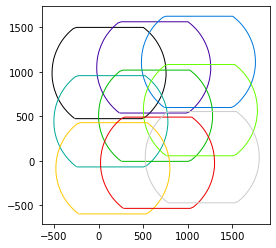

In [18]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch
def vertices_from_mask(mask, coarsen):
    lmask = np.pad(mask,1)
    fig = plt.figure()
    CS = plt.contour(lmask, levels=[0.5])
    pathcoords = CS.allsegs[0][0][::coarsen,:] - 1
    plt.close(fig)
    return pathcoords

def pathpatch_from_mask(mask, offset, coarsen=50, **kwargs):
    pathcoords = vertices_from_mask(mask, coarsen) + np.array(offset)
    pathpatch = PathPatch(Path(pathcoords), **kwargs)
    return pathpatch

color = plt.cm.nipy_spectral(np.linspace(0, 1, cpc.shape[1]))

pathpatches = [pathpatch_from_mask(mask.T, coord, coarsen=50, facecolor='None', edgecolor=color[i]) for i,coord in enumerate(cpc.T)]
fig, ax = plt.subplots()
for pathpatch in pathpatches:
    ax.add_patch(pathpatch)
ax.autoscale_view()
ax.set_aspect('equal')
plt.show()

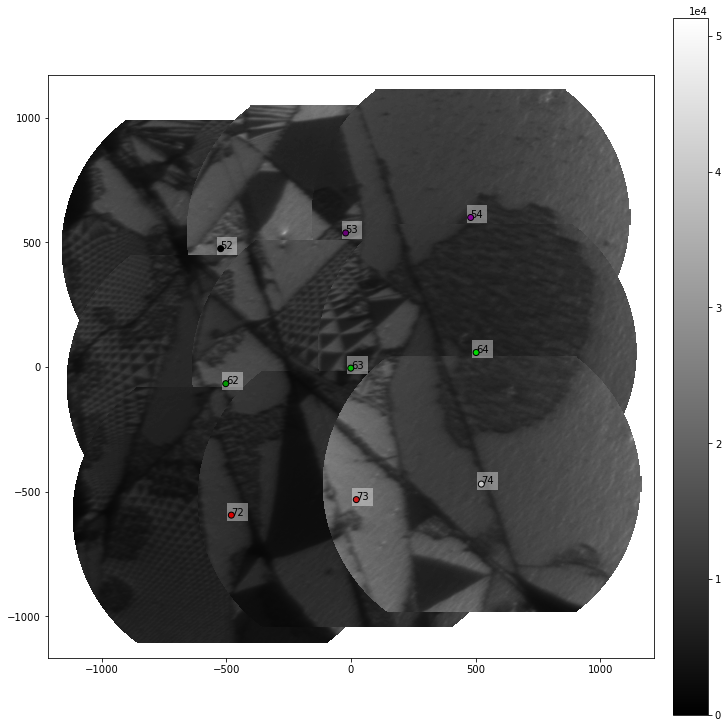

In [19]:
fig,ax = plt.subplots(figsize=[10,10], constrained_layout=True)
base_extent = np.array([-dims[1]//2,dims[1]//2,-dims[2]//2, dims[2]//2])


ax.scatter(*cpc, c=cropindices, cmap='nipy_spectral', 
           zorder=5, linewidths=1, edgecolors='black')
cfac = 4
coarse_mask = da.coarsen(np.all, da.asarray(mask), {0:cfac,1:cfac})
cropdata = da.coarsen(np.mean, data[cropindices], {1:cfac,2:cfac}).persist()

xlim, ylim = np.array([ax.get_xlim(), ax.get_ylim()])
vmin, vmax = da.nanmin(cropdata).compute(), da.nanmax(cropdata).compute()
for i in range(len(cropdata)):
    plt.imshow(np.where(coarse_mask, cropdata[i], np.nan).T, 
               extent=base_extent + np.array([cpc[0,i],cpc[0,i], cpc[1,i],cpc[1,i]]), 
               origin='lower',
               #alpha=0.5,
               cmap='gray',
               vmin=vmin,vmax=vmax,
              )
    plt.annotate(str(cropindices[i]), +cpc[:,i], bbox=dict(facecolor='white', alpha=0.4, edgecolor='none'))
plt.colorbar()

ax.set_xlim(xlim + base_extent[:2])
ax.set_ylim(ylim + base_extent[2:]);

## Step 3: Calculate approximate pixel coordinates from linear transformation

In [20]:
data = data/data.mean(axis=0).compute()

In [21]:
sc = -A_calc @ (stagecoords - center[:,np.newaxis]) #stage-based coordinates in pixels
pc = sc.copy()

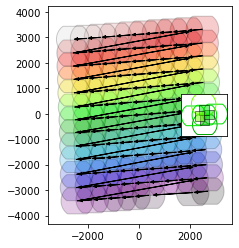

In [87]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
color = plt.cm.nipy_spectral(np.linspace(0, 1, pc.shape[1]))


pathpatches = [pathpatch_from_mask(mask.T, coord-np.array(dims[1:])//2, coarsen=50, facecolor=color[i], alpha=0.2) for i,coord in enumerate(pc.T)]
#facecolor=color[i], alpha=0.2
fig, ax = plt.subplots()
for pathpatch in pathpatches:
    ax.add_patch(pathpatch)
#collection = PatchCollection(pathpatches)
#ax.add_collection(collection)
ax.autoscale_view()
ax.set_aspect('equal')
for i in range(len(pc.T)-1):
    ax.arrow(*pc[:,i], *(pc[:,i+1]-pc[:,i])*0.9, head_width=100, head_length=150, fc='k', length_includes_head=True, overhang=0.4)#, ec='k')
    
#axin = ax.inset_axes([0.9,0.05, 0.1,0.1])#,width="25%", height="25%", loc=4)
axin = inset_axes(ax, width="25%", height="20%", loc=7)
axin.tick_params(labelleft=False, labelbottom=False, direction='in', length=0)
axin.set_xlim(-1200,1200)
axin.set_ylim(-1100,1100)
axin.set_aspect('equal')
ipathpatches = [pathpatch_from_mask(mask.T, coord-pc.T[70]-np.array(dims[1:])//2, coarsen=50, facecolor='none', edgecolor=color[nn[70][i]]) for i,coord in enumerate(pc.T[nn[70]])]
for pathpatch in ipathpatches:
    axin.add_patch(pathpatch)
for i,e in enumerate(e_clip):
    rect = mpatches.Rectangle(e//2-fftsize//2,fftsize,fftsize, alpha=0.5, facecolor=color[nn[70][i+1]], edgecolor='k')
    axin.add_patch(rect)
    
#for axis in ['top','bottom','left','right']:
#    axin.spines[axis].set_color(f"red")
plt.show()

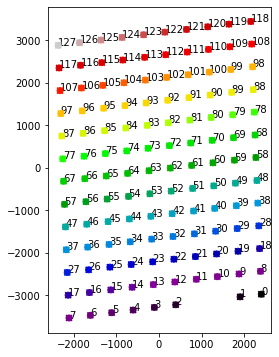

In [27]:
fig,ax = plt.subplots(figsize=[6,6])
base_extent = np.array([-dims[1]//2,dims[1]//2,-dims[2]//2, dims[2]//2])
ax.scatter(*pc, c=np.arange(pc.shape[1]), cmap='nipy_spectral', zorder=5)
ax.scatter(*sc, c=np.arange(pc.shape[1]), cmap='nipy_spectral', zorder=5, marker='x')
for i,im in enumerate(data):
    plt.annotate(str(i), pc[:,i])

ax.set_aspect('equal')

## Step 4: apply digital filters
Start with a large sigma, which you can decrease after succesful iteration of step 5.

In [28]:
output['pc'] = (('iteration', 'direction', 'index'), pc[None,...])
output['sigma'] = (['iteration'], [0])
output['z'] = (['iteration'], [0])
output['weights'] = (['iteration', 'index', 'neighbor_no'], np.zeros((1,len(output.index), n_neighbors)))

## Step 5: Calculating cross-correlations and optimizing positions


In [36]:
sigma = 8 # usualy 24 is a good value to start, squeezing down to ~4 in the end
z = 4

if sigma != 0:
    sobel = da.nan_to_num(only_filter(data, sigma=sigma))
else:
    sobel = data
if z != 1:
    sobel = da.coarsen(np.mean, sobel, axes={1:z,2:z})

sobel.persist()

dims = sobel.shape
base_extent = np.array([-dims[1]//2,dims[1]//2,-dims[2]//2, dims[2]//2])  # for plotting
xx, yy = np.meshgrid(np.arange(-fftsize//2, fftsize//2), np.arange(-fftsize//2, fftsize//2))
corr_mask = (np.abs(xx) < fftsize//2) & (np.abs(yy) < fftsize//2)

In [37]:
interactive(lambda n: plot_stack(sobel, n), 
            n=widgets.IntSlider(1, 0, data.shape[0]-1, 1, continuous_update=False)
           ) 

interactive(children=(IntSlider(value=1, continuous_update=False, description='n', max=127), Output()), _dom_c…

Time: 3.4s
Minimum number of connected components 1.0
w_min: 0.581, w_mean: 0.818
mst_min: 0.582, mst_mean: 0.893


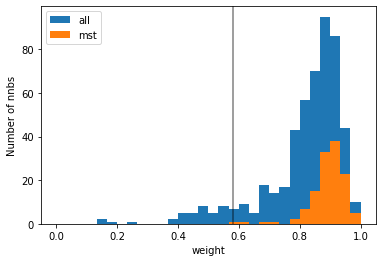

Use all weights larger then w_min, such that the graph is still fully connected...
Time: 4.1s


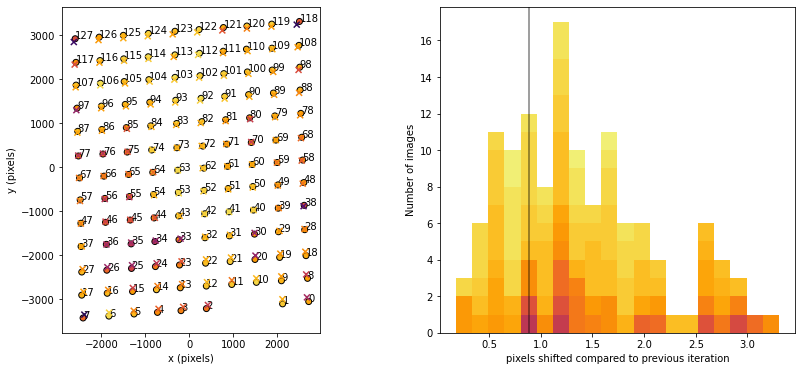

max shift: 2.79 pix, mean shift: 0.88 pix
Time: 3.5s
Minimum number of connected components 1.0
w_min: 0.581, w_mean: 0.818
mst_min: 0.582, mst_mean: 0.894


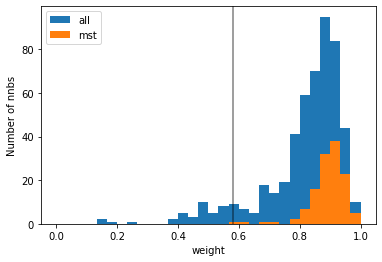

Use all weights larger then w_min, such that the graph is still fully connected...
Time: 4.2s


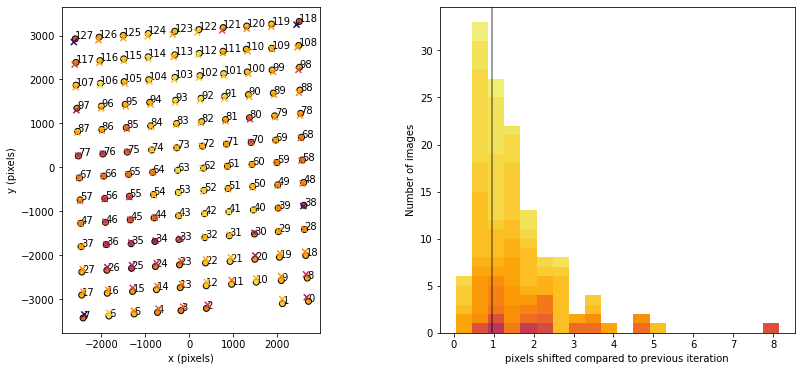

max shift: 8.06 pix, mean shift: 0.97 pix
done


In [41]:
res = {'x': None, 'y': None}

max_iter = 2
mst_iters = []
PLOT_ITERS = True
# Start iteration
for iteration in np.arange(max_iter):
    new_output = output.isel(iteration=[-1])
    new_output = new_output.assign_coords(iteration=new_output.iteration+1)
    new_output.sigma.data = [sigma]
    new_output.z.data = [z]
    t = time.time()
    diffvecs, nn = to_nn_diffvecs(pc / z, n_neighbors=n_neighbors)
    diffvecs = da.from_array(diffvecs, chunks=(6,-1,2))
    
    indexed = da.stack([sobel[nn[:, index]] for index in range(0, nn.shape[1])],
                         axis=1).rechunk({0:6, 1:-1})
    
    
    corrections, w = find_correction_and_w(indexed[:,[0],...], 
                                           indexed[:,1:,...], 
                                           diffvecs,
                                           fftsize // z)

    # Suspicious minus sign
    dr_new = corrections - diffvecs
    dr_new, w_calc = da.compute(dr_new, w)
    print("Time: {:.1f}s".format(time.time() - t))

    print("Minimum number of connected components", 
          connected_bisect(0, w_calc, nn)+1.5)
    w_min = bisect(connected_bisect, 0, 1, args=(w_calc, nn)) - 0.001

    print("w_min: {:.3f}, w_mean: {:.3f}".format(w_min, w_calc.mean()))

    mst = find_maximum_spanning_tree(w_calc, nn)
    mst_w, mst_nn = weights_and_neighbours(mst)
    print("mst_min: {:.3f}, mst_mean: {:.3f}".format(mst_w[mst_w != 0].min(), mst_w[mst_w != 0].mean()))
    if PLOT_ITERS:
        plt.figure(figsize=[6,4])
        plt.hist(w_calc.flatten(), range=[0,1], bins=30, label='all')
        plt.hist(mst_w[mst_w != 0].flatten(), range=[0,1], bins=30, label='mst')
        plt.axvline(w_min, c='black', alpha=0.5)
        plt.xlabel('weight')
        plt.ylabel('Number of nnbs')
        plt.legend()
        plt.show()

    w_alt = np.where(w_calc > w_min-0.001, 
                     (w_calc - w_calc.min()+0.001) / (1-w_calc.min()),
                     0)
    if iteration in mst_iters:
        print("Use only the maximum weight spanning tree")
        drx = transform_to_mst(dr_new[:,:,0], mst, nn)
        dry = transform_to_mst(dr_new[:,:,1], mst, nn)
        res['x'] = minimize(error_func,
                            pc[0] / z, 
                            args=(mst_nn, mst_w**2, drx))
        res['y'] = minimize(error_func,
                            pc[1] / z, 
                            args=(mst_nn, mst_w**2, dry))
        color = np.nanmin(np.where(mst_w != 0, mst_w, np.nan), axis=1)
        cmap = 'viridis'
    else:
        print("Use all weights larger then w_min, such that the graph is still fully connected...")
        res['x'] = minimize(error_func, 
                            pc[0] / z,
                            args=(nn[:,1:], w_alt**2, dr_new[:,:,0]))
        res['y'] = minimize(error_func, 
                            pc[1] / z,
                            args=(nn[:,1:], w_alt**2, dr_new[:,:,1]))
        color = w_calc.mean(axis=1)
        cmap = 'inferno'

    for coord, r in res.items():
        if not r.success:
            print(coord, r.message)

    pc_new = np.stack([res['x'].x, res['y'].x]) * z
    pc_new = pc_new - pc_new.mean(axis=1, keepdims=True)
    pc_new_diff = np.abs(pc_new - pc)
    pc = pc_new
    print("Time: {:.1f}s".format(time.time() - t))
    #Plot and set pc as the results of the optimization to start a new round
    if PLOT_ITERS:
        fig, ax = plt.subplots(ncols=2, figsize=[14,6])
        ax[0].scatter(*pc, c=color, cmap=cmap,  
                      zorder=5, linewidths=1, edgecolors='black', vmin=0, vmax=1)
        ax[0].scatter(*sc, c=w_calc.min(axis=1), cmap=cmap, 
                      zorder=5, marker='x', vmin=0, vmax=1, label='')
        for i,im in enumerate(data):
            ax[0].annotate(str(i), pc[:,i])
        ax[0].set_aspect('equal')
        ax[0].set_xlabel('x (pixels)')
        ax[0].set_ylabel('y (pixels)')
        qhist(np.linalg.norm(pc_new_diff, axis=0), w_calc.mean(axis=1), ax=ax[1], cmap='inferno', binbins=40)
        ax[1].axvline(pc_new_diff.mean(), c='black', alpha=0.5)
        ax[1].set_xlabel('pixels shifted compared to previous iteration')
        ax[1].set_ylabel('Number of images')
        plt.show()
    new_output["pc"].data = pc[None,...]
    new_output["nnbs"].data = nn[None,...]
    new_output["weights"].data[..., 1:] = w_calc
    output = xr.concat([output,new_output], dim='iteration')
    
    if pc_new_diff.max() < 0.2*sigma:
        print("Converged, breaking out of loop, consider decreasing sigma and or z")
        break
    else:
        print(f"max shift: {pc_new_diff.max():.2f} pix, mean shift: {pc_new_diff.mean():.2f} pix")

print('done')
# End iteration

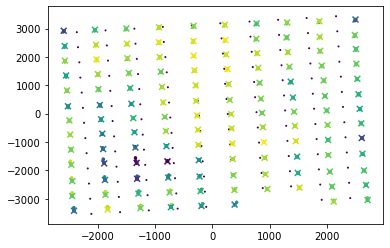

In [42]:
# Render the positions in the last 10 iterations
ldat = output.sel(iteration=0)
plt.scatter(ldat.pc.sel(direction='x'), ldat.pc.sel(direction='y'), c=ldat.weights.isel(neighbor_no=slice(1,None)).mean(dim='neighbor_no'), s=1)
for i in output.iteration[-10:]:
    ldat = output.sel(iteration=i)
    plt.scatter(ldat.pc.sel(direction='x'), ldat.pc.sel(direction='y'), c=ldat.weights.isel(neighbor_no=slice(1,None)).mean(dim='neighbor_no'), s=5)
plt.scatter(ldat.pc.sel(direction='x'), ldat.pc.sel(direction='y'), c=ldat.weights.isel(neighbor_no=slice(1,None)).mean(dim='neighbor_no'), s=35, marker='x')

## (Optional) Step 6: Refine transformation based on best matches

Pick an appropriate threshold for matches to use `w_lim` (usually about 0.9 is good). Compare the new linear transformation `A_prime` with `A_calc`  used before. If significantly different, run the cell below to make `A_prime` the new transformation, and continue back at step 3.

Desired error not necessarily achieved due to precision loss.
[36.96521979 21.32120751]
[[   9950.95  280771.53]
 [-258037.35   21936.24]]
[[  10561.34  250889.  ]
 [-266954.5    31157.17]]
[[0.94 1.12]
 [0.97 0.7 ]]


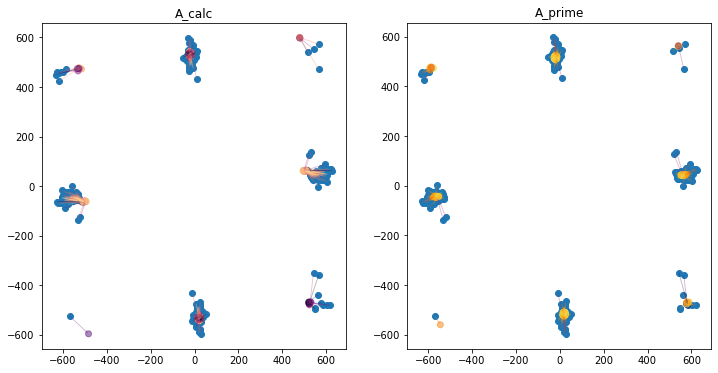

In [33]:
w_lim = 0.7


pcpercont = pc.reshape((pc.shape[0], 1, -1))
pixelcoords = (pcpercont - pcpercont.mean(axis=-1, keepdims=True)).reshape(pc.shape)
cstagecoords = -(stagecoords-center[:,np.newaxis])

red_dr = to_nn_diffvecs(pixelcoords, nn=nn)[0][w_calc > w_lim,:]
red_sc = to_nn_diffvecs(cstagecoords, nn=nn)[0][w_calc > w_lim,:]
res_transform = minimize(base_transformation_error, 
                         A_calc, 
                         args=(red_sc.T, red_dr.T, w_calc[w_calc > w_lim]))
A_prime = res_transform.x.reshape((2,2))
print(res_transform['message'])

fig, ax = plt.subplots(ncols=2, figsize=[12,6])
vmax = np.linalg.norm((A_calc@red_sc.T - red_dr.T), axis=0).max()
ax[0].scatter(*red_dr.T)
ax[0].scatter(*(A_calc @ red_sc.T), c=w_calc[w_calc > w_lim], 
              cmap='magma', alpha=0.5)
ax[0].quiver(*red_dr.T, *(A_calc @ red_sc.T - red_dr.T), w_calc[w_calc > w_lim],
             angles='xy', scale_units='xy', scale=1, alpha=0.3, cmap='magma')
ax[0].set_title('A_calc')
ax[1].scatter(*red_dr.T)
ax[1].scatter(*(A_prime @ red_sc.T), 
              c=np.linalg.norm((A_prime@red_sc.T - red_dr.T), axis=0),
              vmax=vmax, vmin=0, cmap='inferno_r', alpha=0.5)
ax[1].quiver(*red_dr.T, *(A_prime @ red_sc.T - red_dr.T), np.linalg.norm((A_prime@red_sc.T - red_dr.T), axis=0),
             angles='xy', scale_units='xy', scale=1, alpha=0.3, cmap='inferno_r', clim=(0,vmax))
ax[1].set_title('A_prime')
A_prime, A_calc, np.linalg.svd(A_prime), np.linalg.svd(A_calc)

print(np.abs(red_dr.reshape((-1,2)).T - (A_calc @ red_sc.reshape((-1,2)).T)).mean(axis=1) )
with np.printoptions(precision=2):
    print(A_prime, A_calc, A_prime/A_calc, sep='\n')

Now restart step 5


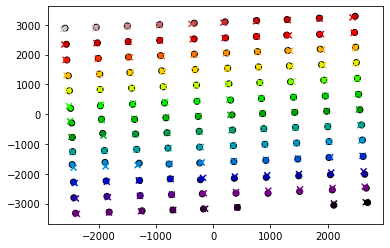

In [34]:
A_calc = A_prime.copy()
plt.scatter(*pc, c=np.arange(sc.shape[1]), cmap='nipy_spectral',  zorder=5, linewidths=1, edgecolors='black')
plt.scatter(*(-A_prime@(stagecoords-center[:,np.newaxis])), c=np.arange(sc.shape[1]), cmap='nipy_spectral', zorder=5, marker='x')
sc = -A_calc @ (stagecoords - center[:,np.newaxis])
pc = sc.copy()
print("Now restart step 5")

### Defining the weighting mask

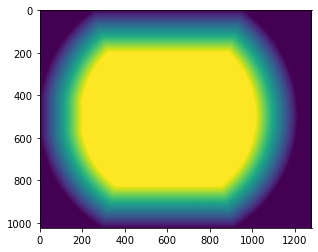

In [44]:
def gen_weight_mask(datashape, radius=610, edgewidth=200):
    xx, yy = np.meshgrid(np.arange(-datashape[2]//2, datashape[2]//2), 
                         np.arange(-datashape[1]//2, datashape[1]//2))
    if edgewidth == 0:
        edgewidth = 1
    circ = ((xx+15)**2 + (yy+37)**2 < outer_radius**2).astype(int)
    # Add a pixel edge of zero, such that we can abuse ndi.distance_transform to get nice sloping edges
    # Afterwards, remove these edges again
    circ = np.pad(circ, 1)
    weight_mask = ndi.distance_transform_edt(circ)
    return np.where(weight_mask > edgewidth, 1, weight_mask / edgewidth)[1:-1,1:-1]

dims = data.shape

if not PEEM:
    outer_radius = 610 
    #outer_radius = 570 
bandwidth = 200

output.attrs["weight_mask"] = (outer_radius, bandwidth)
weight_mask = gen_weight_mask(dims, *output.attrs["weight_mask"])
#weight_mask = np.pad(gen_weight_mask(np.array([1,1280,1024]), *output.attrs["weight_mask"]), ((0,15),(0,37)))

plt.imshow(weight_mask.T)

Text(0, 0.5, 'Number of images')

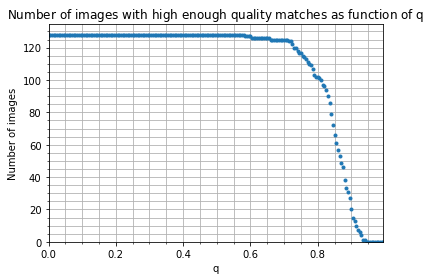

In [62]:
def get_quality_mask(q=0.7):
    m = np.average(w_calc, axis=1, weights=w_calc > w_min) > q
    return m


qs = np.arange(0, 1, 0.005)
plt.plot(qs, [get_quality_mask(q).sum() for q in qs], '.', label=name[50:])
plt.minorticks_on()
plt.grid(True, which='both')
plt.margins(x=0)
plt.ylim(0, None)
plt.title('Number of images with high enough quality matches as function of $q$')
plt.xlabel('q')
plt.ylabel('Number of images')

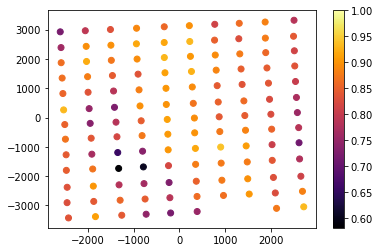

In [50]:
#TODO: make nice widget to select q_thresh
q_thresh = 0.4

plt.scatter(*np.where(get_quality_mask(0, q=q_thresh), pc, np.nan), 
            c=np.average(w_calc, axis=1, weights=w_calc>=w_min),  cmap='inferno',
            zorder=5, vmax=1, vmin=w_min)
plt.scatter(*np.where(get_quality_mask(0, q=q_thresh), np.nan, pc), 
            c=np.average(w_calc, axis=1, weights=w_calc >= w_min),  cmap='inferno',
            zorder=5, marker='x', vmax=1, vmin=w_min)
plt.colorbar()

## (Optional) Step 9: Matching the image intensities.

Optimization terminated successfully.


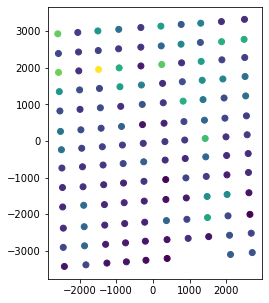

In [56]:
rel_intens = np.ones_like(multipliers)
fig, ax = plt.subplots(ncols=1, figsize=[5,5])

qmask = get_quality_mask(i, q=q_thresh)
diffvecs, nn = to_nn_diffvecs(pc[:, qmask], n_neighbors=n_neighbors)
diffvecs = da.from_array(diffvecs, chunks=(1,-1,2))
#TODO: update to use @gufunc
indexed = da.stack([data[qmask][nn[:, index]] for index in range(0, nn.shape[1])],
                     axis=1).rechunk({0: 1, 1: -1})
regions = da.map_blocks(find_overlap_regions, 
                            indexed, 
                            diffvecs.rechunk({0:1})[..., np.newaxis], 
                            mask=weight_mask,
                            dtype=np.float64, chunks=(1,4,2,2, fftsize, fftsize),
                            new_axis=(-1,-2))
region_intensities = regions[:,:,:,0]
region_weights = regions[:,:,:,1]
region_means = da.nanmean(region_intensities * region_weights, axis=(-1,-2)) / da.nanmean(region_weights, axis=(-1,-2))
region_means = region_means.compute()
region_ratios = region_means[..., 0] / region_means[..., 1]
Iopt_weight = np.where(w_calc[qmask, :4] > w_min - 0.001, 
                       w_calc[qmask, :4], 
                       0)**4
res_I = minimize(error_func, 
                  np.zeros((qmask).sum()), 
                  args=(nn[:,1:], 
                        Iopt_weight, 
                        np.log(region_ratios))
                 )

rel_intens[qmask] = np.exp(res_I.x)
rel = np.exp(res_I.x)
im = ax.scatter(*pc[:, qmask], 
                    c=rel, zorder=5)
ax.set_aspect('equal')
plt.colorbar(im, ax=axs)
print(res_I.message)

## Alternative step 9: use multiplier from container
This method prevents intensity variation within the beam to propagate to the full span of the image.

In [57]:
rel_intens = multipliers

In [59]:
# Add metadata and write metadataoutput to disk
output.attrs["q_thresh"] = q_thresh
output["multiplier"] = ("index", rel_intens)
output.attrs["timestamp"] = datetime.datetime.now().strftime("%Y-%m-%d_%H%M")
output.to_netcdf(os.path.join(folder,name+'stitchdata-'+output.attrs["timestamp"]+'.nc'))

## Step 10: Merging images

First we calculate the edges of the blocks and which images fall in which block.

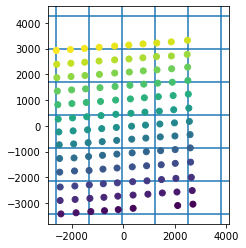

In [60]:
bsize = 1280

xedges = np.arange(np.floor(pc[0].min()), pc[0].max() + data.shape[1], bsize)[::-1]
xmask = np.abs((xedges[:, np.newaxis] - bsize//2) - pc[0]) <  dims[1] + bsize//2

yedges = np.arange(np.floor(pc[1].min()), pc[1].max() + data.shape[2], bsize)[::-1]
ymask = np.abs((yedges[:, np.newaxis] - bsize//2) - pc[1]) < dims[2] + bsize//2
plt.scatter(*pc, c=np.arange(pc.shape[1]),  zorder=5)
for x in xedges:
    plt.axvline(x)
for y in yedges:
    plt.axhline(y)
plt.gca().set_aspect('equal')

images of enough quality: 128 out of 128


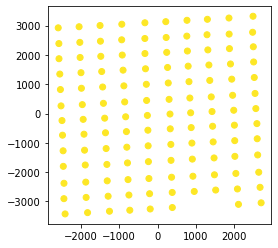

In [64]:
@da.as_gufunc(signature="(i,j),(2),()->(i,j)", output_dtypes=np.float, vectorize=True)
def shift_images(image, shift, order=1):
    """Shift `image` by `shift` pixels."""
    return ndi.shift(image, shift=shift, order=order)

fig, ax = plt.subplots(ncols=1, 
                       figsize=[4, 4], 
                       sharex=True, sharey=True)
ims = []
cs = 10

quality_mask = get_quality_mask(q_thresh)
print("images of enough quality: {} out of {}".format(np.sum(quality_mask), 
                                                      np.sum(I_mask)))
ax.scatter(*pc, c=quality_mask, zorder=5, vmax=1, vmin=0)
total_mask = np.logical_and(xmask[:, None, :], ymask[None, ...])
total_mask = np.logical_and(total_mask, 
                            quality_mask)

normalised_data = np.nan_to_num(data / rel_intens[:, np.newaxis, np.newaxis]) * weight_mask

e_mask = da.from_array(np.pad(weight_mask, 
                              pad_width=((0, bsize-mask.shape[0]), 
                                         (0, bsize-mask.shape[1]))), 
                       chunks=(-1,-1))

im_list = []
for i,x in enumerate(xedges):
    temp_im = []
    for j,y in enumerate(yedges):
        mask_index = total_mask[i,j]
        if np.count_nonzero(mask_index) > 0:
            locdata = normalised_data[mask_index]
            locdata = da.pad(locdata, 
                             pad_width=((0, 0), 
                                        (0, bsize - locdata.shape[1]), 
                                        (0, bsize - locdata.shape[2])), 
                             mode='constant')
            locdata = locdata.rechunk({0:cs, 1:-1, 2:-1})
            shifts = da.from_array([x, y] - pc.T[mask_index], chunks=(cs, -1))
            image_sum = shift_images(locdata, 
                                     shifts, 1).sum(axis=0)
            image_weight = shift_images(da.stack([e_mask] * mask_index.sum()).rechunk({0: cs}), 
                                        shifts, 1).sum(axis=0)
            normed = (image_sum / image_weight)
            temp_im.append(normed)
        else:
            temp_im.append(da.full((bsize,bsize), 
                                   fill_value=np.nan, 
                                   chunks=(-1, -1)))
    im_list.append(temp_im)
ims.append(da.block(im_list).to_zarr(os.path.join(folder, name , f'results.zarr'), 
                                     compute=False, overwrite=True))

In [65]:
# Actual computation
for im in ims:
    t = time.time()
    da.compute(im)
    print(f'{time.time() - t:.1f}s')

14.8s


## Reload image from disk and display

In [79]:
im = da.from_zarr(os.path.join(folder, name , f'results.zarr'))

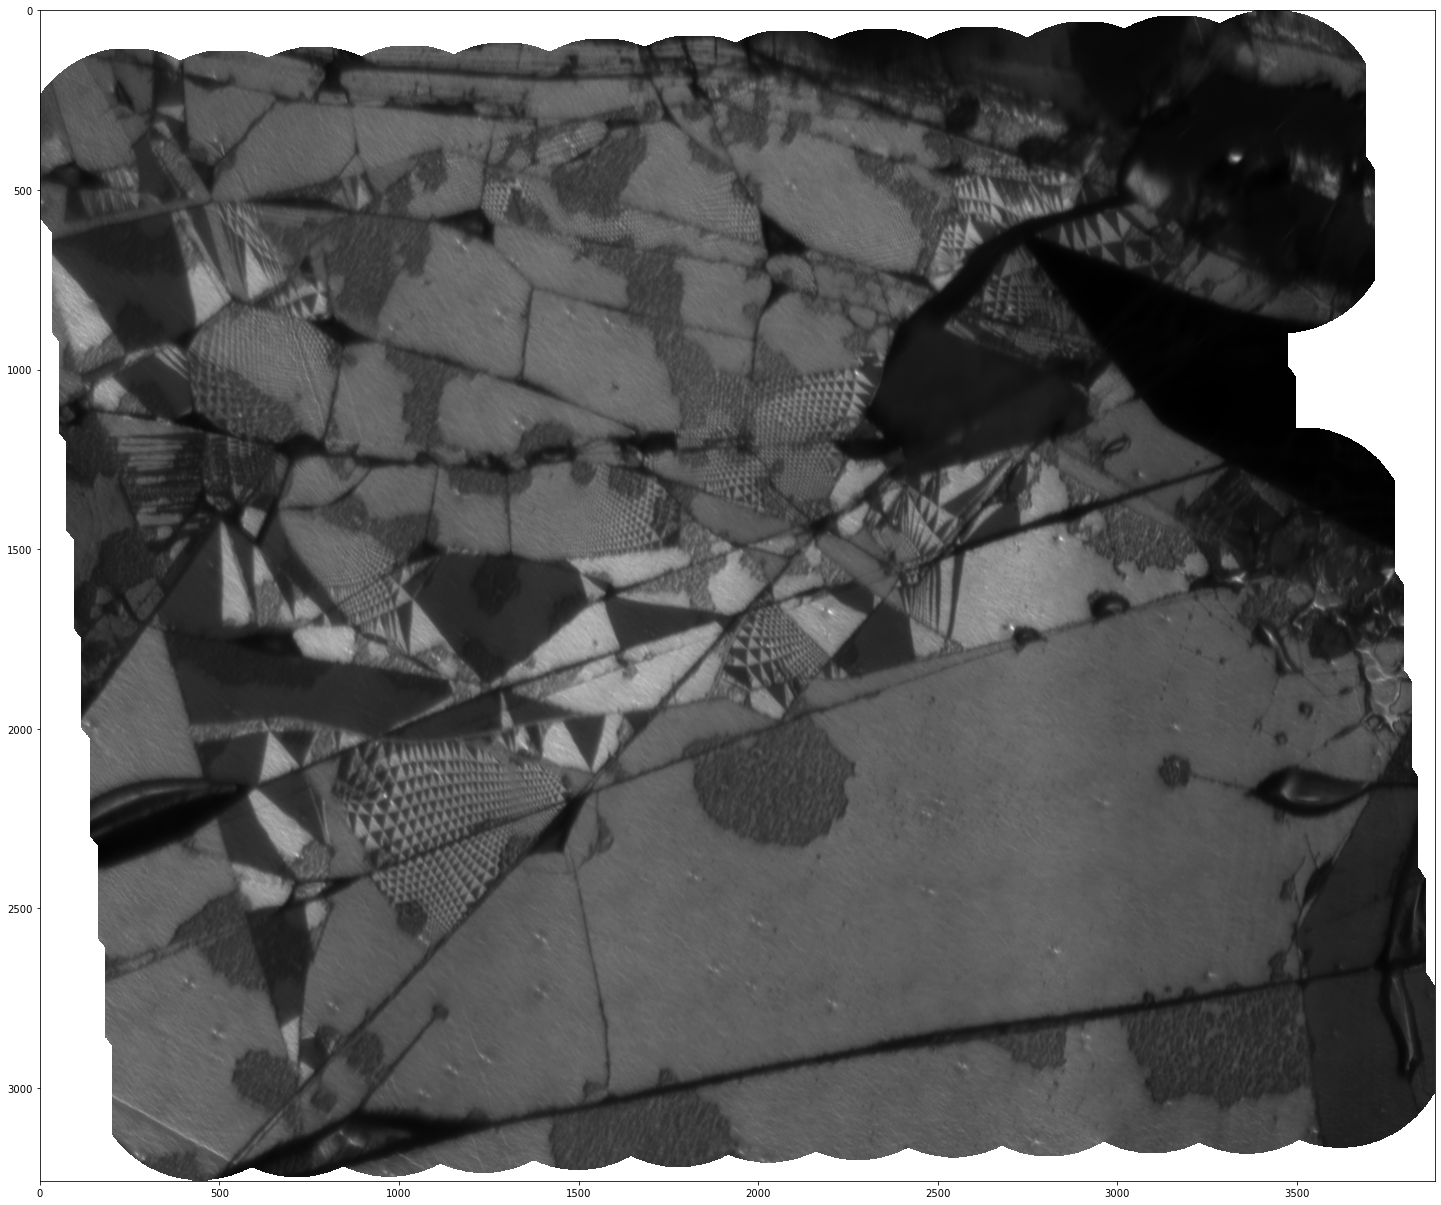

In [69]:
small = trim_nans(da.coarsen(np.mean, im, axes={0:2,1:2}).compute())
small = small / np.nanmax(small, axis=(0,1), keepdims=True)
plt.figure(figsize=[25,22])
plt.imshow(small, vmax=np.nanmax(small), cmap='gray')

## Saving data

In [80]:
final_image = np.nan_to_num(trim_nans(im).compute(), 
                            nan=np.nan, 
                            posinf=np.nan, 
                            neginf=np.nan)

In [81]:
im

dask.array<from-zarr, shape=(7680, 8960), dtype=float64, chunksize=(1280, 1280), chunktype=numpy.ndarray>

In [82]:
final_image = final_image - np.nanmin(final_image, axis=(0,1))
final_image = final_image / np.nanmax(final_image, axis=(0,1))
tifimage = (final_image*(2**16 - 1)).T.astype(np.uint16)

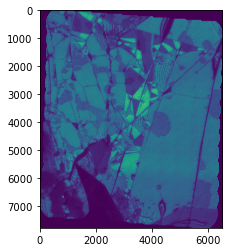

In [83]:
plt.imshow(tifimage.squeeze())

In [84]:
# Save tif
from skimage.io import imsave
output_fname = 'stitch_'+output.attrs["scriptversion"]+'_'+output.attrs["timestamp"]+f'_sobel_{sigma}_bw_{bandwidth}'
imsave(os.path.join(folder, name, output_fname+'.tif'), tifimage)

In [ ]:
# Optionally: save full precision float image to npy
np.save(os.path.join(folder, name, output_fname+'.npy'), final_image)

In [85]:
# Cleanup results{i}.zarr
import shutil
shutil.rmtree(os.path.join(folder, name, f'results.zarr'))